# Spectrograms - CNN Test

In [1]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from keras.optimizers import Adam

import sqlalchemy
from sqlalchemy import create_engine, inspect

import math
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
from pprint import pprint

import os
import sys
import time
from datetime import datetime
from contextlib import redirect_stdout
import matplotlib.pyplot as plt

%run functions.ipynb

In [2]:
# Time the run
start_time = time.time()

## Import datasets

In [3]:
# Import the data
engine = create_engine("sqlite:///voice.sqlite")

# View all of the classes
inspector = inspect(engine)
table_names = inspector.get_table_names()
table_names

['alexaval',
 'alexbval',
 'alexgval',
 'alexrval',
 'aval',
 'bval',
 'chroma1',
 'chroma10',
 'chroma11',
 'chroma12',
 'chroma2',
 'chroma3',
 'chroma4',
 'chroma5',
 'chroma6',
 'chroma7',
 'chroma8',
 'chroma9',
 'chromastd',
 'deltachroma1',
 'deltachroma10',
 'deltachroma11',
 'deltachroma12',
 'deltachroma2',
 'deltachroma3',
 'deltachroma4',
 'deltachroma5',
 'deltachroma6',
 'deltachroma7',
 'deltachroma8',
 'deltachroma9',
 'deltachromastd',
 'deltaenergy',
 'deltaenergyentropy',
 'deltamfcc1',
 'deltamfcc10',
 'deltamfcc11',
 'deltamfcc12',
 'deltamfcc13',
 'deltamfcc2',
 'deltamfcc3',
 'deltamfcc4',
 'deltamfcc5',
 'deltamfcc6',
 'deltamfcc7',
 'deltamfcc8',
 'deltamfcc9',
 'deltaspectralcentroid',
 'deltaspectralentropy',
 'deltaspectralflux',
 'deltaspectralrolloff',
 'deltaspectralspread',
 'deltazcr',
 'demographic',
 'diagnosis',
 'energy',
 'energyentropy',
 'gval',
 'habits',
 'mfcc1',
 'mfcc10',
 'mfcc11',
 'mfcc12',
 'mfcc13',
 'mfcc2',
 'mfcc3',
 'mfcc4',
 'mfcc5

In [4]:
# Tables to import
import_tables = ['diagnosis', 'rval', 'gval', 'bval', 'aval']

In [5]:
# Initialise a dictionary to hold dataframes
dataframes = dict()

# Loop through each table
for table in import_tables:
    
    # Dataframe name
    df_name = f'{table}_df'
    
    # Create dataframe
    dataframes[df_name] = pd.read_sql(
        f'SELECT * FROM {table}',
        engine
    )

## Preprocessing

### Define the target variable

In [6]:
# Sort the diagnosis dataframe
dataframes['diagnosis_df'] = dataframes['diagnosis_df'].sort_values(by='id').reset_index(drop=True)

# Isolate the diagnosis column
y = dataframes['diagnosis_df']['diagnosis'].copy()

# Encode the target variable, ignore subtype
y = y.apply(encode_binary)
y

0      1
1      0
2      1
3      1
4      1
      ..
199    0
200    1
201    0
202    0
203    1
Name: diagnosis, Length: 204, dtype: int64

In [7]:
# Check the aval_df
dataframes['aval_df'].describe()

,voice156,voice142,voice195,voice181,voice022,voice036,voice208,voice037,voice023,voice180,...,voice166,voice199,voice012,voice204,voice205,voice013,voice007,voice198,voice167,voice173
count,37350.0,37350.0,37350.0,37350.0,37350.0,37350.0,37350.0,37350.0,37350.0,37350.0,...,37350.0,37350.0,37350.0,37350.0,37350.0,37350.0,37350.0,37350.0,37350.0,37350.0
mean,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
25%,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
50%,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
75%,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
max,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0


__NOTE__: The A-channel is all the same, might not be adding value.

### Reshape the feature variables

In [8]:
# Input shape
width_px = 225
height_px = 166

# alex
# width_px = 227
# height_px = 227

num_channels = 3 # since RGB

# Define inputs
input_shape = (height_px, width_px, num_channels)
input_reshape = (height_px, width_px)

,voice001,voice002,voice003,voice004,voice007,voice008,voice009,voice010,voice011,voice012,...,voice199,voice200,voice201,voice202,voice203,voice204,voice205,voice206,voice207,voice208
0,47,47,47,47,47,47,47,47,47,47,...,47,47,47,47,47,47,47,47,47,47
1,47,47,47,47,47,47,47,47,47,47,...,47,47,47,47,47,47,47,47,47,47
2,43,43,43,43,43,43,43,43,43,44,...,43,43,45,43,43,43,43,43,43,43
3,20,20,19,21,20,20,20,20,20,25,...,24,24,41,22,20,20,21,20,20,19
4,19,19,18,20,20,20,19,19,19,24,...,24,23,41,21,20,19,20,19,19,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37345,199,200,200,200,199,200,200,199,200,162,...,160,200,199,200,199,200,200,200,199,200
37346,225,226,226,226,225,226,226,225,226,162,...,160,226,225,226,225,226,226,226,225,226
37347,225,225,225,225,224,225,226,225,225,165,...,163,225,225,225,225,225,225,225,225,225
37348,247,247,246,247,247,247,246,247,246,237,...,237,247,247,247,246,247,247,247,247,246


,voice001,voice002,voice003,voice004,voice007,voice008,voice009,voice010,voice011,voice012,...,voice199,voice200,voice201,voice202,voice203,voice204,voice205,voice206,voice207,voice208
0,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
1,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
2,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
3,13,13,13,13,13,14,13,13,14,15,...,14,14,16,14,14,12,13,14,13,13
4,13,13,13,13,13,14,13,13,14,15,...,14,14,16,13,14,12,13,14,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37345,119,119,119,120,118,119,119,119,119,103,...,102,119,119,119,119,119,119,119,119,119
37346,127,127,127,128,127,127,128,127,127,103,...,102,127,127,127,127,127,127,127,127,128
37347,128,128,128,128,127,128,128,128,128,104,...,104,128,128,128,127,128,128,128,128,128
37348,156,156,157,157,156,157,157,156,157,150,...,150,157,156,157,157,157,157,157,156,157


,voice001,voice002,voice003,voice004,voice007,voice008,voice009,voice010,voice011,voice012,...,voice199,voice200,voice201,voice202,voice203,voice204,voice205,voice206,voice207,voice208
0,99,99,99,99,99,99,99,99,99,99,...,99,99,99,99,99,99,99,99,99,99
1,99,99,99,99,99,99,99,99,99,99,...,99,99,99,99,99,99,99,99,99,99
2,93,93,92,93,92,93,93,93,93,94,...,93,93,97,93,93,92,93,93,92,92
3,53,54,51,56,55,54,53,54,53,64,...,62,61,88,58,55,53,56,54,52,52
4,52,53,50,55,53,53,52,52,52,62,...,61,60,87,56,54,52,54,53,51,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37345,117,117,117,117,118,117,117,117,117,138,...,138,117,117,117,117,117,117,117,117,117
37346,131,131,131,131,132,131,131,131,131,139,...,138,131,131,131,131,131,131,131,131,131
37347,130,130,130,130,131,130,130,130,130,138,...,138,130,130,130,130,130,130,130,130,130
37348,121,121,121,121,121,121,121,121,121,123,...,123,121,121,121,121,121,121,121,121,121


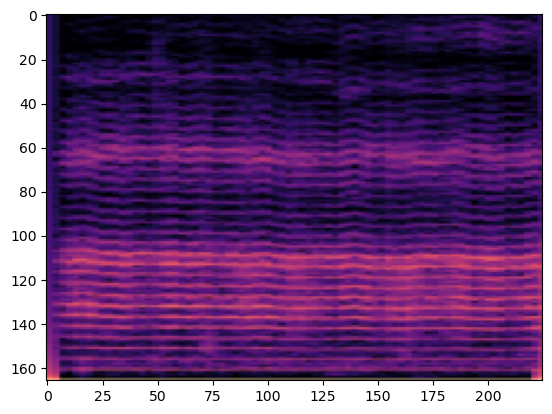

In [9]:
# Dataframe order
# rgba_order = ['rval_df', 'gval_df', 'bval_df', 'aval_df']
rgb_order = ['rval_df', 'gval_df', 'bval_df']
# rgb_order = ['alexrval_df', 'alexgval_df', 'alexbval_df']

# Initialise list to hold the dataframes
rgba_df_list = []

# Loop through all the dataframes
for df in rgb_order:
    
    # Sort the columns
    dataframes[df] = dataframes[df].sort_index(axis=1)
    display(dataframes[df])
    
    # Define the df columns
    df_cols = dataframes[df].columns

    # Reshape to its original dimensions
    data = np.array(
        [dataframes[df][col].values.reshape(input_reshape) for col in df_cols]
    )

    # Append to the list
    rgba_df_list.append(data)

# Define the feature variables
X = np.stack(rgba_df_list, axis=-1)

# Display the first for confirmation
plt.imshow(X[0])
plt.show()

### Split and Scale

In [10]:
# Split the preprocessed data to training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [11]:
# Reshape the data
X_train_reshaped = X_train.reshape((
    X_train.shape[0], # total number of samples
    height_px * width_px * num_channels # total number flattened
))

X_test_reshaped = X_test.reshape((
    X_test.shape[0],
    height_px * width_px * num_channels
))

In [12]:
# Normalize training data to be between 0 and 1
X_scaler = MinMaxScaler()

# Scale the data
X_train_scaled = X_scaler.fit_transform(X_train_reshaped)
X_test_scaled = X_scaler.fit_transform(X_test_reshaped)

# Reshape the data back to the original
X_train_scaled = X_train_scaled.reshape((
    X_train_scaled.shape[0],
    height_px,
    width_px,
    num_channels
))

X_test_scaled = X_test_scaled.reshape((
    X_test_scaled.shape[0],
    height_px,
    width_px,
    num_channels
))

## Initial Test Model

__GUIDELINES__

- The number of filters for convolutional layers should:
    - Be a value to the power of 2
    - Increase for each following layer (i.e. `32`, `64`, `128`)
- The number of neurons for the fully connected layers should:
    - Be a value to the power of 2
    - Decrease for each following layer (i.e. `64`, `32`)
- Kernel size must be an odd integer

In [13]:
# Define the CNN model
cnn = Sequential()

# Define the pool size
pool_size = (2, 2)

# Add the first convolutional layer
cnn.add(Conv2D(
    filters = 32,
    kernel_size = (3, 3),
    activation = 'relu',
    input_shape = (height_px, width_px, num_channels)
))
cnn.add(MaxPooling2D(pool_size))

# Add the second convolutional layer
cnn.add(Conv2D(
    filters = 64,
    kernel_size = (3, 3),
    activation = 'relu'
))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size))

# Add the third convolutional layer
cnn.add(Conv2D(
    filters = 128,
    kernel_size = (3, 3),
    activation = 'relu'
))
# cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size))

# Add the fourth convolutional layer
cnn.add(Conv2D(
    filters = 256,
    kernel_size = (3, 3),
    activation = 'relu'
))
cnn.add(MaxPooling2D(pool_size))

# Add the fifth convolutional layer
# cnn.add(Conv2D(
#     filters = 512,
#     kernel_size = (3, 3),
#     activation = 'relu'
# ))
# cnn.add(Dropout(0.5))
# cnn.add(MaxPooling2D(pool_size))

# Flatten the output before feeding to the fully connected layers
cnn.add(Flatten())

# Add dense layers for classification
cnn.add(Dense(
    units = 256,
    activation = 'relu'
))

cnn.add(Dense(
    units = 64,
    activation = 'relu'
))

# Add the output layer
cnn.add(Dense(
    units = 1,
    activation = 'sigmoid'
))

# Display the summary
cnn.summary()

# cnn.add(Conv2D(32, 3, strides=2, padding='same', activation='relu'))
# cnn.add(BatchNormalization())
# cnn.add(MaxPooling2D(pool_size=(2, 2)))
# cnn.add(BatchNormalization())
# cnn.add(Conv2D(64, 3, padding='same', activation='relu'))
# cnn.add(BatchNormalization())
# cnn.add(MaxPooling2D(pool_size=(2, 2)))
# cnn.add(BatchNormalization())
# cnn.add(Conv2D(128, 3, padding='same', activation='relu'))
# cnn.add(BatchNormalization())
# cnn.add(MaxPooling2D(pool_size=(2, 2)))
# cnn.add(BatchNormalization())
# cnn.add(Flatten())
# cnn.add(Dense(256, activation='relu'))
# cnn.add(BatchNormalization())
# cnn.add(Dropout(0.5))
# cnn.add(Dense(1, activation='softmax'))

# cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 164, 223, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 82, 111, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 109, 64)       18496     
                                                                 
 batch_normalization (Batch  (None, 80, 109, 64)       256       
 Normalization)                                                  
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 40, 54, 64)        0         
 g2D)                                                            
                                                        

In [14]:
# Compile the model
cnn.compile(
    optimizer = 'adam',
    # optimizer = Adam(lr=0.001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [15]:
# Train the model
cnn.fit(
    X_train_scaled,
    y_train,
    epochs = 15,
    shuffle = True, # reduce risk of overfitting
    verbose = 1
)

Epoch 1/15
5/5 [==============================] - 2s 357ms/step - loss: 2.9264 - accuracy: 0.5098
Epoch 2/15
5/5 [==============================] - 2s 294ms/step - loss: 0.6607 - accuracy: 0.6405
Epoch 3/15
5/5 [==============================] - 1s 297ms/step - loss: 0.5907 - accuracy: 0.7190
Epoch 4/15
5/5 [==============================] - 2s 335ms/step - loss: 0.5933 - accuracy: 0.7190
Epoch 5/15
5/5 [==============================] - 1s 294ms/step - loss: 0.5587 - accuracy: 0.7190
Epoch 6/15
5/5 [==============================] - 1s 292ms/step - loss: 0.5710 - accuracy: 0.7190
Epoch 7/15
5/5 [==============================] - 1s 292ms/step - loss: 0.5395 - accuracy: 0.7255
Epoch 8/15
5/5 [==============================] - 1s 293ms/step - loss: 0.5154 - accuracy: 0.7255
Epoch 9/15
5/5 [==============================] - 1s 294ms/step - loss: 0.4966 - accuracy: 0.7647
Epoch 10/15
5/5 [==============================] - 1s 294ms/step - loss: 0.4615 - accuracy: 0.7712
Epoch 11/15
5/5 [==

In [16]:
# Evaluate the model using the test data
model_loss, model_accuracy = cnn.evaluate(
    X_test_scaled,
    y_test,
    verbose = 2
)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

2/2 - 0s - loss: 0.5594 - accuracy: 0.7255 - 193ms/epoch - 97ms/step
Loss: 0.5593672394752502, Accuracy: 0.7254902124404907


## Save Results to Performance Tracker

In [17]:
# Create dictionary to save the results
results_dict = dict()

current_time = datetime.now()
results_dict['timestamp'] = current_time
results_dict['runtime'] = time.time() - start_time
results_dict['model_loss'] = model_loss
results_dict['model_accuracy'] = model_accuracy

In [18]:
# Change message
change_message = input("Changes from previous iteration: ")

# Append to results_dict
results_dict['change_message'] = change_message

Changes from previous iteration:  added batch normalisation to 2nd conv layer


In [19]:
# Display the dictionary
results_dict

{'timestamp': datetime.datetime(2024, 1, 7, 10, 15, 22, 841851),
 'runtime': 30.24592089653015,
 'model_loss': 0.5593672394752502,
 'model_accuracy': 0.7254902124404907,
 'change_message': 'added batch normalisation to 2nd conv layer'}

In [20]:
# Model summary folder path
summary_path = '../resources/tracker/cnn_summary/'
num_files = len(os.listdir(summary_path))

# Export summary to text file
with open(f'{summary_path}cnn_summary_{num_files}.txt', 'w') as f:
    with redirect_stdout(f):
        cnn.summary()
        pprint(results_dict)

In [21]:
# Convert the dictionary to a dataframe
results_df = pd.DataFrame(results_dict, index=[0])
results_df.head()

,timestamp,runtime,model_loss,model_accuracy,change_message
0,2024-01-07 10:15:22.841851,30.245921,0.559367,0.72549,added batch normalisation to 2nd conv layer


In [22]:
# Performance tracker
tracker_path = "../resources/tracker/cnn_performance_tracker.csv"

# Model percentage
model_pct = round(model_accuracy, 3)

# Check if the CSV exists
if os.path.exists(tracker_path):
    
    # Read the existing CSV
    tracker_df = pd.read_csv(tracker_path)
    
    # Append the new row of data
    updated_df = pd.concat([tracker_df, results_df], ignore_index=True)
    
    # Update the CSV file
    updated_df.to_csv(tracker_path, index=False)
    
    # Export model to HDF5 file
    cnn.save(f'../models/cnn/run_{len(tracker_df)}_{model_pct}.h5', save_format='h5')

else:    
    # Export to CSV
    results_df.to_csv(tracker_path, index=False)
    
    # Export model to HDF5 file
    cnn.save(f'../models/cnn/run_0_{model_pct}.h5', save_format='h5')

/Users/alyssahondrade/anaconda3/envs/dev/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Save Model Results to CSV

In [23]:
# Check the prediction's output probabilities
predicted_prob = cnn.predict(X_test_scaled)
clean_prob = np.round(predicted_prob, 2)

# Round to the nearest integer and flatten
clean_predicted = np.round(predicted_prob).astype(int).flatten()

# Convert to a dataframe for readability
output_prob = pd.DataFrame({
    'Actual': y_test,
    'Predicted': clean_predicted,
    'Probability': clean_prob.flatten()
})

output_prob

2/2 [==============================] - 0s 52ms/step


,Actual,Predicted,Probability
115,0,1,0.69
79,1,1,0.62
140,1,1,0.69
111,1,1,0.95
132,1,1,0.66
159,1,1,0.65
5,1,1,0.74
86,0,1,0.57
20,1,1,0.56
108,1,1,0.77


In [24]:
output_prob.loc[output_prob['Actual'] != output_prob['Predicted']]

,Actual,Predicted,Probability
115,0,1,0.69
86,0,1,0.57
46,0,1,0.74
201,0,1,0.59
129,0,1,0.64
65,0,1,0.70
134,0,1,0.69
56,0,1,0.67
31,0,1,0.66
118,0,1,0.74


In [25]:
incorrect_idx = output_prob.loc[output_prob['Actual'] != output_prob['Predicted']].index
incorrect_idx

Index([115, 86, 46, 201, 129, 65, 134, 56, 31, 118, 85, 42, 96, 16], dtype='int64')

In [26]:
dataframes['diagnosis_df'].iloc[incorrect_idx]

,id,diagnosis,subtype,vhi_score,rsi_score,reflux_indicated,vhi_zscore,vhi_impact
115,voice120,healthy,no subtype,22,4,0,0.89,1
86,voice091,healthy,no subtype,0,14,1,-0.58,0
46,voice049,healthy,no subtype,4,20,1,-0.32,0
201,voice206,healthy,no subtype,0,6,0,-0.58,0
129,voice134,healthy,no subtype,86,0,0,5.16,4
65,voice070,healthy,no subtype,24,0,0,1.02,2
134,voice139,healthy,no subtype,22,11,0,0.89,1
56,voice061,healthy,no subtype,19,12,0,0.68,1
31,voice034,healthy,no subtype,19,16,1,0.68,1
118,voice123,healthy,no subtype,0,3,0,-0.58,0
